# DGA Detection - Data Processing

In [1]:
%pip install --upgrade pip
%pip install pandas scikit-learn scipy numpy alibi tldextract pyarrow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 12.6 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import tldextract
import re

from scipy.stats import entropy
from sklearn.model_selection import train_test_split 
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

## DGTA Benchmarking data set

We test our dataset with the DGTA Benchmark data set (https://data.mendeley.com/datasets/2wzf9bz7xr/1)

In [3]:
df_dgta = pd.read_parquet('data/dgta-benchmark.parquet')
df_dgta = df_dgta.rename(columns={"domain": "Domain"})
df_dgta

,Domain,class
0,b'0dev.null.googlepages.com',legit
1,b'0.static.wix.com',legit
2,b'a2sportsguy.googlepages.com',legit
3,b'a2zexperts.googlepages.com',legit
4,b'a2zvs.setmore.com',legit
...,...,...
84943,b'adsunflower.com',legit
84945,b'meride.tv',legit
84947,b'sanalpazar.com',legit
84948,b'continular.com',legit


In [5]:
df_new = pd.read_csv("data/dgta.csv")

Total number of classes 55


<Axes: ylabel='class'>

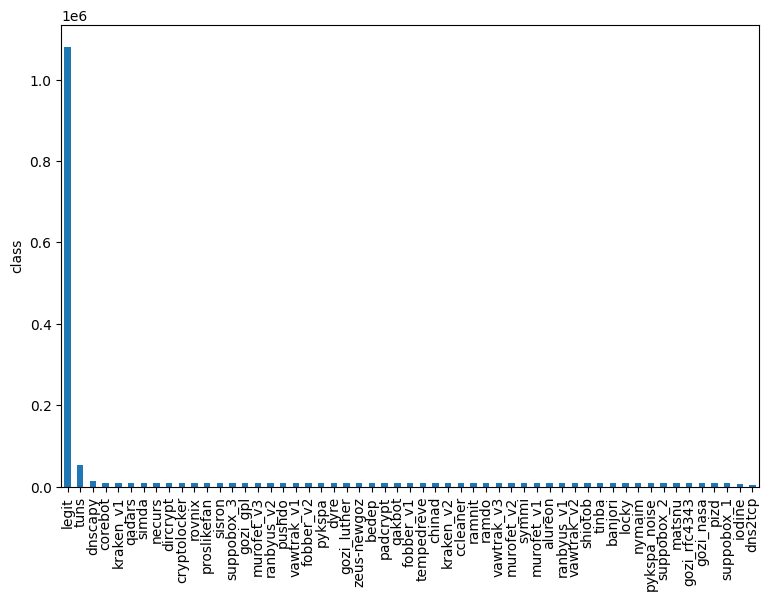

In [6]:
print(f"Total number of classes {len(df_new['class'].value_counts())}")
df_new["class"].value_counts().plot(kind='bar', figsize=(9,6), ylabel='class')

In [7]:
df_test = df_new.drop(['Domain'], axis=1)
df_test['class'] = pd.Categorical(df_test['class'])
df_test['class'] = df_test['class'].cat.codes

df_without_label = df_test.drop(['class'], axis=1)

In [8]:
kmeans = KMeans(n_clusters=2)

kmeans.fit(df_without_label)

y_pred = kmeans.predict(df_without_label)

X = df_test[['Entropy', 'FQDN_full_count', 'FQDN_upper_count', 'FQDN_lower_count', 'FQDN_numeric_count', 'FQDN_special_count', 'Labels_length', 'Labels_max', 'Labels_average', 'Subdomain_length']].to_numpy()
y_true = df_test['class'].to_numpy()

y_true = np.where(y_true != 20, 1, y_true)
y_true = np.where(y_true == 20, 0, y_true)

/home/smachmeier/projects/heiDGA/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [9]:
print(classification_report(y_true, y_pred, labels=[*range(2)]))

              precision    recall  f1-score   support

           0       0.48      0.49      0.48   1080697
           1       0.00      0.00      0.00    576537

    accuracy                           0.32   1657234
   macro avg       0.24      0.25      0.24   1657234
weighted avg       0.31      0.32      0.32   1657234



In [10]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X, y_true)
y_pred = clf.predict(X)

In [11]:
print(classification_report(y_true, y_pred, labels=[*range(2)]))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96   1080697
           1       0.96      0.88      0.92    576537

    accuracy                           0.94   1657234
   macro avg       0.95      0.93      0.94   1657234
weighted avg       0.95      0.94      0.94   1657234



/tmp/ipykernel_6587/3668146473.py:10: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  fig.dist = 10


<Axes3D: title={'center': 'PCA'}, xlabel='Entropy', ylabel='FQDN_full_count', zlabel='Class'>

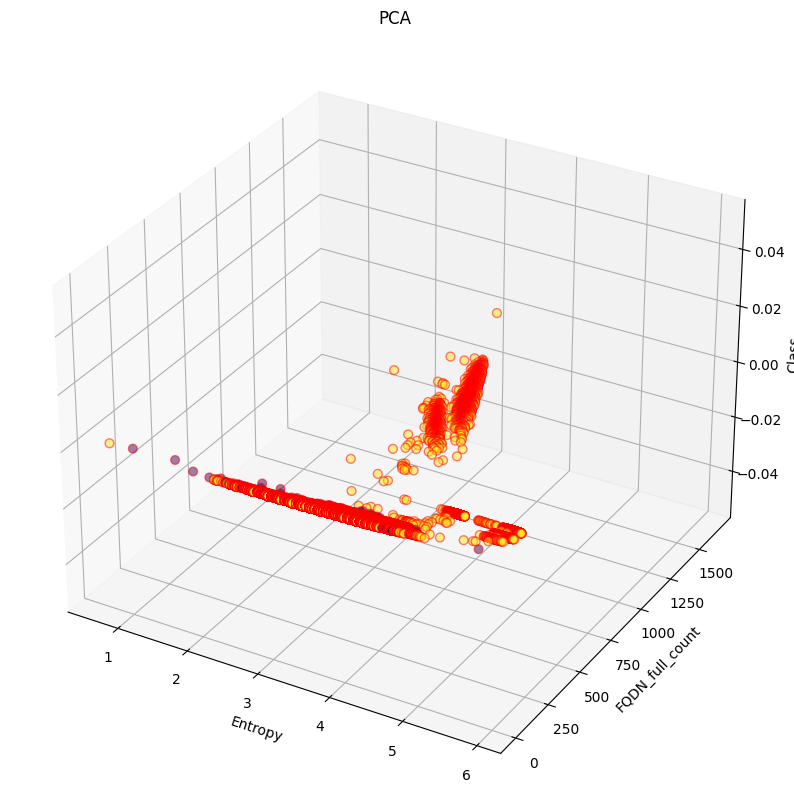

In [12]:
fig = plt.figure(figsize=(10,10))

fig = fig.add_subplot(111, projection='3d')
fig.scatter(X[:,0],X[:,1], c=y_pred, edgecolor='red', s=40, alpha = 0.5)

fig.set_title("PCA")
fig.set_xlabel("Entropy")
fig.set_ylabel("FQDN_full_count")
fig.set_zlabel("Class")
fig.dist = 10
fig